# Pandera Basical Usage

[「PyCon mini Shizuoka 2021」](https://pycon-shizu.connpass.com/event/228219/)で発表させていただいた際に利用したソースコードになります。

In [1]:
import pandas as pd
import numpy as np
import pandera as pa
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 基本的な使い方

In [6]:
df = pd.DataFrame({
    "column1": [1, 4, 0, 10, 9],
    "column2": [-1.3, -2.1, -2.9, -10.1, -20.4],
    "column3": ["value_1", "value_2", "value_3", "value_4", "value_1115"],
})
df

,column1,column2,column3
0,1,-1.3,value_1
1,4,-2.1,value_2
2,0,-2.9,value_3
3,10,-10.1,value_4
4,9,-20.4,value_1115


In [30]:

# define schema
schema = pa.DataFrameSchema({
    "column1": pa.Column(pa.Int), # Integer型
    "column2": pa.Column(float, checks=pa.Check.lt(-2.0)), # -2.0より小さい値を取るfloat
    "column3": pa.Column(str, checks=[
        # "value_"から始まる string型で "value_\d{1,2}$" と言う正規表現を満たす
        pa.Check.str_startswith("value_"),
        # 対象カラムシリーズを引数に、boolean or boolean Seriesを出力するカスタム関数を設定することでCheckを自作できる
        pa.Check(lambda s: s.str.match(pat="value_\d{1,2}$"), error="Irregular format for column3"),
    ]),
},
    index=pa.Index(pa.Int),
    strict=True, # Schemaで定義したカラムが欠けている or 定義外のカラムが含まれている場合、DataFrameSchema　Errorを吐きます
    coerce=True # 型をschemaに合わせる
)


try:
    validated_df = schema(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)
    errors = err


A total of 2 schema errors were found.

Error Counts
------------
- schema_component_check: 2

Schema Error Summary
--------------------
                                                    failure_cases  n_failure_cases
schema_context column  check                                                      
Column         column2 less_than(-2.0)                     [-1.3]                1
               column3 Irregular format for column3  [value_1115]                1

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.failure_cases  # dataframe of schema errors
    err.data  # invalid dataframe
```



- passするゆるゆるスキーマ
    - 成功するとvalidateされたdfが返されます。
    - DataFrameSchemaのcoerce引数をTrueに指定すると、指定した型に変換され返されます

In [31]:

loose_schema = pa.DataFrameSchema({
    "column1": pa.Column(int), # Integer型
})

try:
    validated_df = loose_schema(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)
    errors = err
validated_df

,column1,column2,column3
0,1,-1.3,value_1
1,4,-2.1,value_2
2,0,-2.9,value_3
3,10,-10.1,value_4
4,9,-20.4,value_1115


## スキーマ保存機能

to_script()はあるけど、from_script関数はないみたいです。うーむ。

In [32]:
schema.to_yaml("sample_schema.yaml")

/Users/takubojunpei/miniforge3/envs/finance/lib/python3.9/site-packages/pandera/schema_statistics.py:163: UserWarning: Only registered checks may be serialized to statistics. Did you forget to register it with the extension API? Check `<lambda>` will be skipped.
  warnings.warn(


- Warningが出ている様に、lambda関数で自作したcheckはskipされます。
    - これを解決するためには、`@extensions.register_check_method`を利用してpa.Checkから呼び出せるカスタム関数にする必要があります。
- 注: pythonの`int`クラスを型に利用すると、`value` propertyがないと言う、AttributionErrorが発生するので、
pa.Intを型指定に利用しています。



例えば、pa.Check.isin()で指定したパラメータもちゃんとyamlに記録されます。

`sample_schema_with_parameter.yaml`を確認ください。

In [39]:
custom_elements = [1,2,3]
loose_schema = pa.DataFrameSchema({
    "column1": pa.Column(pa.Int, checks=[pa.Check.isin(custom_elements)]), # Integer型
})
loose_schema.to_yaml("sample_schema_with_parameter.yaml")

## Checkの使い方

- その他、pandera.Checks.Checkの classmethodでvalidation関数がたくさん提供されています。

In [72]:
from pandera import Column, DataFrameSchema, Check, Index

strict_schema = DataFrameSchema(
    {
        "column1": Column(int, checks=[

            # value == 1になっているか検証(以下のsampleでは、failureになる想定)
            Check.equal_to(value=1), #  column1の全ての要素が1であるかチェックする
            Check.eq(value=1), # alias for equal_to
            # value != -999になっているか検証
            Check.not_equal_to(value=-999),
            Check.ne(value=-999), # alias for not_equal_to
            
            # value >= 0になっているか検証
            Check.greater_than_or_equal_to(min_value=0),
            Check.ge(min_value=0), # alias for greater_than_or_equal_to
            
            # value > 0になっているか検証
            Check.greater_than(min_value=0),
            Check.gt(min_value=0), # alias for greater_than
            
            # 10 >= value >= 0になっているか検証
            Check.in_range(min_value=0, max_value=10), 
            
            # value in {1,2,3,4} になっているか検証
            Check.isin(allowed_values=[1,2,3,4])
        ]),
        "column2": Column(float, checks=[
            # 下記のようにcustom check_fnを利用する場合のみ、error, name引数を設定できる。
            Check(lambda s: s < -1.2,  
                  error="values should be less than -1.2",
                  name="Customized less_than"
                 )
        ]
                         ),
        # you can provide a list of validators
        "column3": Column(str, [
            Check.str_contains(pattern="value"),
            Check(lambda s: s.str.startswith("value")),
            Check(lambda s: s.str.split("_", expand=True).shape[1] == 2)
        ])
    },
    index=Index(int),
    strict=False,
    coerce=True,
)

df = pd.DataFrame({
    "column1": [1, 2, 3, 4, 5],
    "column2": [-1, -2.0, -3.0, -4.1, -5.2],
    "column3": ["value_1", "value_2", "value_3", "value_4", "value_5"],
})

In [73]:
# 1個目のvalidationが失敗に終わると、その時点でerrors.SchemaErrorを返してしまう。
try:
    strict_schema.validate(df)
except pa.errors.SchemaError as err:
    print(err)


<Schema Column(name=column1, type=<class 'int'>)> failed element-wise validator 0:
<Check equal_to: equal_to(1)>
failure cases:
   index  failure_case
0      1             2
1      2             3
2      3             4
3      4             5


In [74]:
try:
    # lazy=Trueにすることで、1個エラーが発生したとしても複数validation結果を返してくれる
    # https://pandera.readthedocs.io/en/v0.4.0/lazy_validation.html
    strict_schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)


A total of 4 schema errors were found.

Error Counts
------------
- schema_component_check: 4

Schema Error Summary
--------------------
                                                               failure_cases  n_failure_cases
schema_context column  check                                                                 
Column         column1 equal_to(1)                      [2.0, 3.0, 4.0, 5.0]                4
                       isin({1, 2, 3, 4})                              [5.0]                1
               column2 values should be less than -1.2                [-1.0]                1

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.failure_cases  # dataframe of schema errors
    err.data  # invalid dataframe
```



## Hypothesis

- 以下では、平均値が、train時と同じ分布とは思えないくらいズレているよ！という検定をするために
`t検定`と呼ばれる統計的検定をします！

In [76]:
import scipy
from scipy import stats

In [77]:
# hypoを使って分布の変化を捉えよう。

def custom_ttest(array_1, array_2):
    stat, pvalue = scipy.stats.ttest_ind(array_1, array_2)
    print("t-検定統計量:", stat, "\n p値:", pvalue)
    return stat, pvalue


def debug_rel(stat, pvalue, alpha=0.1):
    """
    stat: 検定統計量
    pvalue: p-値(帰無仮説が正しいとしたときに、どれだけレアなケースが実データで起きてしまったのかを表す確率)
    """
    # import pdb; pdb.set_trace()
    # 両側検定のpvalueなので、1/2にして有意水準alphaと比較します。
    #超えていない = 帰無仮説（A, B群で平均値が等しいとする仮説）が確率alphaしか起きないめっちゃ珍しい事象であると推論できると言うこと。
    return stat > 0 and pvalue / 2 < alpha


schema = pa.DataFrameSchema({
     "height_in_feet": pa.Column(pa.Float, [
         pa.Hypothesis(
             test=custom_ttest,
             samples=["A", "B"],
             groupby="group",
             # assert that the mean height of group "A" is greater
             # than that of group "B"
             relationship=lambda stat, pvalue, alpha: (
                 stat > 0 and pvalue / 2 < alpha
             ),
             # set alpha criterion to 1%
             relationship_kwargs={"alpha": 0.01},
             error="2群の平均値が有意に異なると言えません。"
         )
     ]),
     "group": pa.Column(pa.String),
 })
sample_size = 1000
df = (
     pd.DataFrame({
         "id": range(sample_size * 2),
         "group": ["A"] * sample_size + ["B"] * sample_size,
         "height_in_feet": np.r_[np.random.uniform(low=10, high=16, size=sample_size), 
                                 np.random.uniform(low=6, high=12, size=sample_size)],


     })
 )
schema.validate(df)[["height_in_feet", "group"]]

t-検定統計量: 51.097011312528494 
 p値: 0.0


,height_in_feet,group
0,12.462700,A
1,10.814572,A
2,15.586530,A
3,13.157925,A
4,11.035250,A
...,...,...
1995,6.579795,B
1996,11.946367,B
1997,7.962770,B
1998,6.888846,B


かなり稚拙なコードですが、A/Bのグループが近づいてくると、t検定が棄却できなくなってきて（A, B群で平均値が等しいとする仮説が珍しいとはいえない）validation failedになります。

t-検定統計量: 5.4338683379473265 
 p値: 4.028086919116797e-07
passed for 0.0
t-検定統計量: 2.535702602393236 
 p値: 0.012803003399041332
passed for 0.4
t-検定統計量: 4.078460057066638 
 p値: 9.23577177427666e-05
passed for 0.8
t-検定統計量: 2.919646010312091 
 p値: 0.004347929225230588
passed for 1.2000000000000002
t-検定統計量: 3.793530611669863 
 p値: 0.00025705567348883047
passed for 1.6
t-検定統計量: 0.3488181682402316 
 p値: 0.7279741328947638
<Schema Column(name=height_in_feet, type=float)> failed series or dataframe validator 0:
<Check _hypothesis_check: 2群の平均値が有意に異なると言えません。>


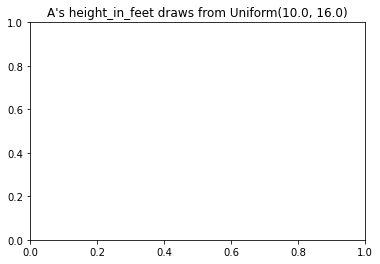

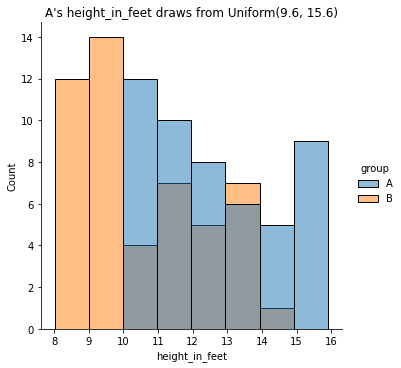

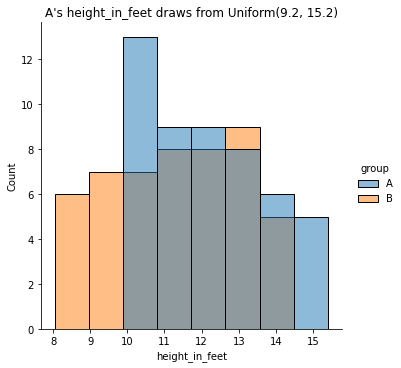

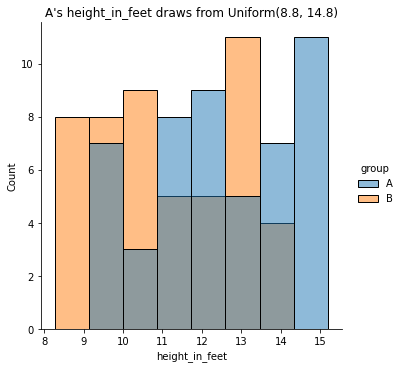

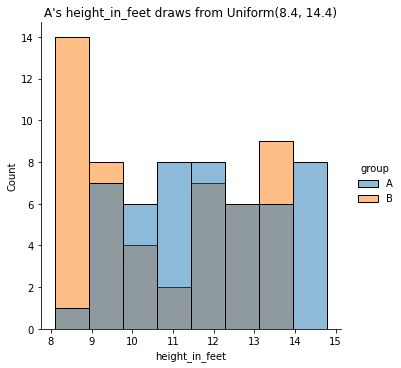

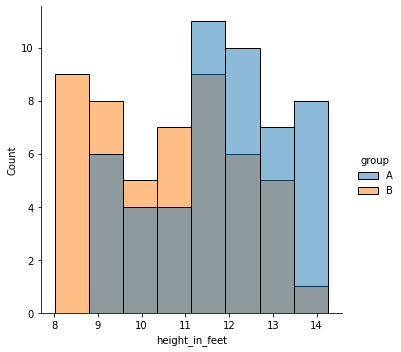

In [82]:
sample_size = 50

for diff in np.linspace(0, 4, num=11):
    df = (
         pd.DataFrame({
             "id": range(sample_size * 2),
             "group": ["A"] * sample_size + ["B"] * sample_size,
             "height_in_feet": np.r_[np.random.uniform(low=10 - diff, high=16 - diff, size=sample_size), 
                                     np.random.uniform(low=8, high=14, size=sample_size)],


         })
     )
    
    try:
        schema.validate(df)[["height_in_feet", "group"]]
        print(f"passed for {diff}")
        plt.title(f"A's height_in_feet draws from Uniform({10 - diff}, {16 - diff})")
        sns.displot(data=df, x="height_in_feet", hue="group")
    except pa.errors.SchemaError as err:
        print(err)
        
        break

## datetime型もちゃんと扱える。
- これをちゃんと実装すれば、いちいちpd.to_datetime(*)実装せずに、coerceでvalidate&型変換しても良いかもしれないですね。
(*)kaggleとかでデータ分析するときに大抵文字列のtimestampをdatetime変換するときに愛用しています。

- ただ、pa.DataFrameSchemaでは、tz-awareな型を指定することはできなさそうです。

In [87]:
# alerted_at: Series[pd.DatetimeTZDtype] = pa.Field(dtype_kwargs={"unit": "ns", "tz": "UTC"})

datetime_schema = pa.DataFrameSchema({
    "column1": pa.Column(
        pandas_dtype=pa.DateTime,
    ), 
})


In [88]:
datetime_schema.to_yaml("datetime.yaml")